# Lecture15 発展的な話題

最後の回は、今までの講義を振り返るとともに、折に触れて紹介したChatGPTなどの大規模言語モデル(LLM)とデータサイエンスとの関係性についていくつか話題を実例を含めながら紹介する。

- 深層学習から発展し、ChatGPTなどのもとになった、Transformerについて、動かしてみる。（時系列データ予測もやってみる）
- LLMの活用例
 - CSVデータエージェント
 - Q&A with sources

## Transformer

ここでは「機械学習エンジニアのためのTransfomers」の例を実際に動かしてみます。

ここでは、HuggingFaceというオープンソースのモデルやデータをあつめたハブからpipeline()関数を使ってローカルにtransformerのモデルをダウンロード（実際にはcolabの仮想マシンに）して使っています。


https://github.com/nlp-with-transformers/notebooks/blob/main/01_introduction.ipynb

## Transformerの歴史
Transformerとは、深層学習のアーキテクチャの一つであり、Googleにより発明されました。それ以降、BERTやGPTなどが開発され、現在のGPT3.5やGPT4すなわちChatGPTのもとになるTransformerが開発されてきました。

![Transformerの歴史](https://raw.githubusercontent.com/nlp-with-transformers/notebooks/48e4a5e5c44b86e1593c0945a49af9675cfd7158//images/chapter01_timeline.png)

## 「エンコーダー・デコーダ」アーキテクチャ

深層学習の中で、RNN(再帰型ニューラルネットワーク）を用いて、入力文字の順序を持つ列を、状態にエンコードする、エンコーダーブロックと、状態からこれを、出力文字列に、やはりRNNを用いてでコードするデコードブロックを組み合わせたものが、トランスフォーマの基本となるアーキテクチャです。
![](https://raw.githubusercontent.com/nlp-with-transformers/notebooks/48e4a5e5c44b86e1593c0945a49af9675cfd7158//images/chapter01_enc-dec.png)

In [1]:
!pip install transformers  sentencepiece
!pip install diffusers accelerate scipy safetensors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.4 MB/s eta 0:00:00


例題とするテキスト（英語）です、~~Amazon~~EC業者への問い合わせのメールのようです。

In [2]:
text = """Dear Amazon, last week I ordered an Optimus Prime action figure \
from your online store in Germany. Unfortunately, when I opened the package, \
I discovered to my horror that I had been sent an action figure of Megatron \
instead! As a lifelong enemy of the Decepticons, I hope you can understand my \
dilemma. To resolve the issue, I demand an exchange of Megatron for the \
Optimus Prime figure I ordered. Enclosed are copies of my records concerning \
this purchase. I expect to hear from you soon. Sincerely, Bumblebee."""

## テキスト分類の例 
pipleline関数に、タスク種別を引数に指定すると、適切なモデルを自動選択して、モデルのインスタンスをcolab仮想マシンに生成します。（具体的なモデルを指定することもできます）。

In [3]:
from transformers import pipeline
#distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)

classifier = pipeline("text-classification")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


このようにして、与えた文章に対して感情を分析してくれます。スコア付き。

In [6]:
classifier(text)

[{'label': 'NEGATIVE', 'score': 0.9015460014343262}]

一度、モデルを作れば、あとは何度も別のテキストを試せます。ディープラーニングの父、ヒントン教授のインタビューから

In [7]:
text_hinton="""Geoff Hinton 

Yes, I do. I strongly believe that. I strongly believe that when we eventually understand how the brain works,
 that's going to give us lots of psychological insight too. Just as understanding chemistry at the atomic level, 
 understanding of how molecules bump into each other and what happens, 
 gives us lots of insight into the gas laws. 
"""

In [8]:
classifier(text_hinton)

[{'label': 'POSITIVE', 'score': 0.9994831085205078}]

## 固有語の識別

named entity(名前のあるエンティティ)の識別

In [10]:
import pandas as pd
#dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf

ner_tagger = pipeline("ner", aggregation_strategy="simple")

outputs = ner_tagger(text)
pd.DataFrame(outputs)  

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


,entity_group,score,word,start,end
0,ORG,0.879010,Amazon,5,11
1,MISC,0.990859,Optimus Prime,36,49
2,LOC,0.999755,Germany,90,97
3,MISC,0.556571,Mega,208,212
4,PER,0.590256,##tron,212,216
5,ORG,0.669692,Decept,253,259
6,MISC,0.498349,##icons,259,264
7,MISC,0.775362,Megatron,350,358
8,MISC,0.987854,Optimus Prime,367,380
9,PER,0.812096,Bumblebee,502,511


## 質問に答える

In [11]:

reader = pipeline("question-answering")
question = "What does the customer want?"
outputs = reader(question=question, context=text)
pd.DataFrame([outputs]) 

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


,score,start,end,answer
0,0.631292,335,358,an exchange of Megatron


## 要約をする

In [12]:

summarizer = pipeline("summarization")
outputs = summarizer(text, max_length=60, clean_up_tokenization_spaces=True)
print(outputs[0]['summary_text'])
     

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


 Bumblebee ordered an Optimus Prime action figure from your online store in Germany. Unfortunately, when I opened the package, I discovered to my horror that I had been sent an action figure of Megatron instead. As a lifelong enemy of the Decepticons, I hope you can understand


## 翻訳では、FuguMTを使ってみます。

In [13]:
from transformers import pipeline
fugu_translator = pipeline('translation', model='staka/fugumt-en-ja')
fugu_translator(outputs[0]['summary_text'])

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


[{'translation_text': 'BumblebeeはドイツのオンラインストアでOptimus Primeのアクションフィギュアを注文しました。残念ながら、パッケージを開けたとき、私はMegatronのアクションフィギュアを代わりに送ったことを恐怖に感じました。Decepticonsの生涯の敵として、理解できることを願っています。'}]

もう少し本格的な

In [14]:
translator = pipeline("translation", model='Hoax0930/marian-finetuned-kde4-en-to-ja_kftt')
translator(outputs[0]['summary_text'])

[{'translation_text': 'バンブルビーはあなたのドイツのオンラインストアからのプロヴィデンスプライムアクション図をオーダーしました。'}]

## 画像生成
テキストから画像を生成する有名な、stablefusionも試せます。

In [ ]:
!pip install diffusers transformers accelerate scipy safetensors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


メモリ利用量が無料版のcolabを超えるかもしれません。その場合は、クラッシュします。がメモリがリセットされるので再実行します。

  0%|          | 0/50 [00:00<?, ?it/s]

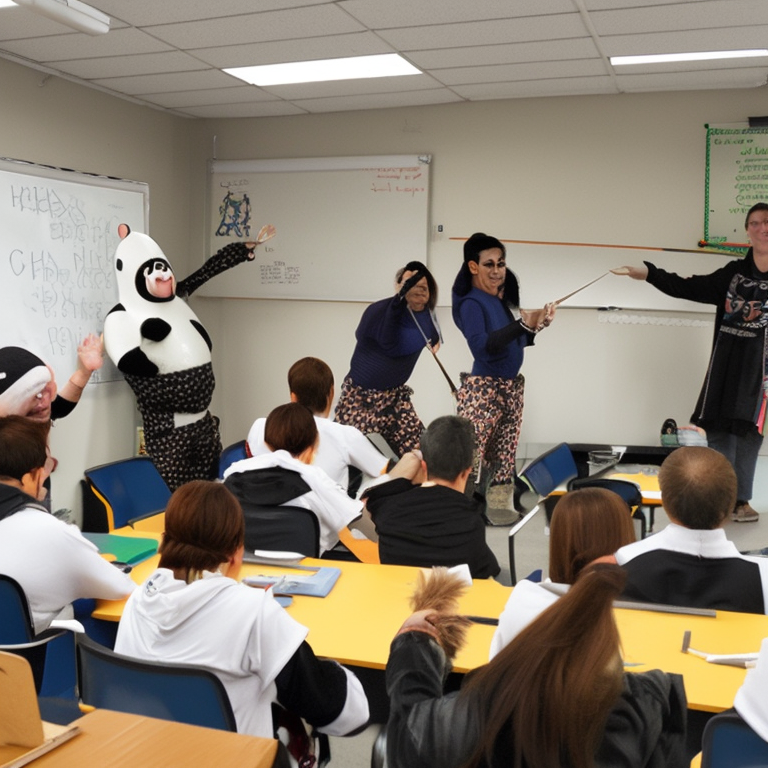

In [ ]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch

model_id = "stabilityai/stable-diffusion-2"

scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "The professor in panda outfits is teaching in a busy and packed class room. Some student is throwing spears to him"
image = pipe(prompt).images[0]
image

In [15]:
!pip install langchain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.7/949.7 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.3 MB/s eta 0:00:00


In [1]:
from langchain import HuggingFacePipeline
from langchain import PromptTemplate,  LLMChain

llm = HuggingFacePipeline.from_model_id(model_id="bigscience/bloom-1b7", task="text-generation", model_kwargs={"temperature":0, "max_length":64})

template = """Question: {question}

Answer: Let's think step by step."""
prompt = PromptTemplate(template=template, input_variables=["question"])

llm_chain = LLMChain(prompt=prompt, llm=llm)

question = "What is electroencephalography?"

print(llm_chain.run(question))

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


 First, we need to understand what is an electroencephalogram. An electroencephalogram is a recording of brain activity. It is a recording of brain activity that is made by placing electrodes on the scalp. The electrodes are placed


いちど、ロードするとあとは大丈夫。

In [2]:
question = "Why nuclear fusion is so difficult from enginnering perspective?"

print(llm_chain.run(question))

 First, we need to understand the basic principles of nuclear fusion. Nuclear fusion is a process in which two nuclei are brought together by the action of a strong electric field. The two nuclei are brought together by the action


## OpenAIのapiのkeyを持っている場合は。

In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
# get a token: https://platform.openai.com/account/api-keys

from getpass import getpass

OPENAI_API_KEY = getpass()

··········


In [ ]:
import os

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [ ]:
from langchain import PromptTemplate,  LLMChain
from langchain.llms import OpenAI

template = """Question: {question}

Answer: Let's think step by step."""
prompt = PromptTemplate(template=template, input_variables=["question"])

llm = OpenAI()

llm_chain = LLMChain(prompt=prompt, llm=llm)

question = "What is electroencephalography?"

print(llm_chain.run(question))



Electroencephalography (EEG) is a medical test that measures and records the electrical activity of the brain. It is typically used to diagnose neurological conditions, track brain activity during sleep, or monitor the effects of certain drugs. EEGs are noninvasive, meaning they do not involve any surgical procedures or the introduction of any foreign substances into the body. The process involves attaching electrodes to the scalp to measure the electrical activity of the brain and then sending the information to a computer for analysis.


## 有料のOpenAIのapi_keyを持っていなくても、無料のHugging Faceを使うことができます。

In [ ]:
!pip install huggingface_hub 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.0 MB/s eta 0:00:00


In [ ]:
# get a token: https://huggingface.co/docs/api-inference/quicktour#get-your-api-token

from getpass import getpass

HUGGINGFACEHUB_API_TOKEN = getpass()

··········


In [ ]:
import os
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

In [ ]:
from langchain import PromptTemplate,  LLMChain
from langchain import HuggingFaceHub

template = """Question: {question}

Answer: Let's think step by step."""
prompt = PromptTemplate(template=template, input_variables=["question"])

llm = HuggingFaceHub(repo_id="google/flan-ul2", model_kwargs={"temperature":0.1,
                                                                "max_length":64})

llm_chain = LLMChain(prompt=prompt, llm=llm)

question = "What is electroencephalography?"

print(llm_chain.run(question))

Electroencephalography is the process of measuring brain activity by recording electrical signals in the brain. The
